# <ins>**Data Wrangling**</ins>

---

In [1]:
# Required Imports

import pandas as pd
import json
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

### Salary Calculation based on the most relevant job match through vectorization

In [2]:
df_job_postings = pd.read_csv("../data/transformed/postings_final.csv")

df_job_postings["industry"] = df_job_postings["industry"].apply(json.loads)
df_job_postings["speciality"] = df_job_postings["speciality"].apply(json.loads)
df_job_postings["benefits"] = df_job_postings["benefits"].apply(json.loads)

In [3]:
pd.set_option("display.max_columns", None)
df_job_postings.head()

,job_id,job_posting_url,company_id,name,country,state,city,title,description,formatted_experience_level,work_type,remote_allowed,min_salary,max_salary,normalized_salary,currency,pay_period,views,applies,listed_time,original_listed_time,expiry,url,industry,speciality,benefits,employee_count,follower_count,time_recorded
0,921716,https://www.linkedin.com/jobs/view/921716/?trk...,2774458,CORCORAN SAWYER SMITH,US,NJ,JERSEY CITY,MARKETING COORDINATOR,Job descriptionA leading real estate firm in N...,OTHER,FULL_TIME,0,17.0,20.0,38480.0,USD,HOURLY,20,2.0,2024-04-17 23:45:08,2024-04-17 23:45:08,2024-05-17 23:45:08,https://www.linkedin.com/company/corcoran-sawy...,"[""REAL ESTATE""]","[""REAL ESTATE"", ""NEW DEVELOPMENT""]",[],402,2351,1970-01-20 19:56:49.275
1,10998357,https://www.linkedin.com/jobs/view/10998357/?t...,64896719,THE NATIONAL EXEMPLAR,US,OHIO,MARIEMONT,ASSITANT RESTAURANT MANAGER,The National Exemplar is accepting application...,OTHER,FULL_TIME,0,45000.0,65000.0,55000.0,USD,YEARLY,8,0.0,2024-04-16 14:26:54,2024-04-16 14:26:54,2024-05-16 14:26:54,https://www.linkedin.com/company/the-national-...,"[""RESTAURANTS""]","""[OTHER]""",[],15,40,1970-01-20 19:54:39.321
2,23221523,https://www.linkedin.com/jobs/view/23221523/?t...,766262,"ABRAMS FENSTERMAN, LLP",US,NEW YORK,LAKE SUCCESS,SENIOR ELDER LAW / TRUSTS AND ESTATES ASSOCIAT...,Senior Associate Attorney - Elder Law / Trusts...,OTHER,FULL_TIME,0,140000.0,175000.0,157500.0,USD,YEARLY,16,0.0,2024-04-12 04:23:32,2024-04-12 04:23:32,2024-05-12 04:23:32,https://www.linkedin.com/company/abrams-fenste...,"[""LAW PRACTICE""]","[""CIVIL LITIGATION"", ""CORPORATE & SECURITIES L...",[401(K)],222,2427,1970-01-20 19:48:17.299
3,91700727,https://www.linkedin.com/jobs/view/91700727/?t...,1481176,DOWNTOWN RALEIGH ALLIANCE,US,NORTH CAROLINA,RALEIGH,ECONOMIC DEVELOPMENT AND PLANNING INTERN,Job summary:The Economic Development & Plannin...,OTHER,INTERNSHIP,0,14.0,20.0,35360.0,USD,HOURLY,9,4.0,2024-04-18 16:01:39,2024-04-18 16:01:39,2024-05-18 16:01:39,https://www.linkedin.com/company/downtownralei...,"[""NON-PROFIT ORGANIZATIONS""]","[""ECONOMIC DEVELOPMENT"", ""CLEAN & SAFE AMBASSO...",[],22,7825,1970-01-20 19:57:39.851
4,103254301,https://www.linkedin.com/jobs/view/103254301/?...,81942316,RAW CEREAL,US,CA,LOS ANGELES,PRODUCER,Company DescriptionRaw Cereal is a creative de...,OTHER,CONTRACT,1,60000.0,300000.0,180000.0,USD,YEARLY,7,1.0,2024-04-11 18:43:39,2024-04-11 18:43:39,2024-05-11 18:43:39,https://www.linkedin.com/company/raw-cereal,"[""DESIGN SERVICES""]","""[OTHER]""",[],11,447,1970-01-20 19:47:41.202


In [4]:
# Combine relevant features into a single text column
df_job_postings["combined_features"] = df_job_postings.apply(
    lambda x: f"{x['title']} {x['country']} {x['name']} {x['formatted_experience_level']} {x['work_type']}",
    axis=1,
)

In [ ]:
# Create TF-IDF matrix from combined features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_job_postings['combined_features'])

In [ ]:
def find_similar_job(index, tfidf_matrix, df):
    cosine_similarities = cosine_similarity(tfidf_matrix[index], tfidf_matrix).flatten()
    similar_indices = cosine_similarities.argsort()[:-50:-1]
    for i in similar_indices:
        if pd.notna(df.iloc[i]['normalized_salary']) and df.iloc[i]['normalized_salary'] > 0:
            return df.iloc[i]['normalized_salary']
    return None

In [ ]:
# Fill missing salaries
for index, row in df_job_postings[(df_job_postings['normalized_salary']==0 )|(df_job_postings['normalized_salary'].isnull())].iterrows():
    if pd.isna(row['normalized_salary']) or row['normalized_salary'] == 0:
        similar_salary = find_similar_job(index, tfidf_matrix, df_job_postings)
        df_job_postings.at[index, 'salary_calc'] = similar_salary

In [ ]:
df_job_postings['salary_calc'].isna().value_counts()

In [ ]:
df_job_postings['normalized_salary'].isna().value_counts()

In [ ]:
df_job_postings['normalized_salary'] = df_job_postings.apply(lambda row: row['salary_calc'] if row['normalized_salary'] == 0 else row['normalized_salary'], axis=1)

### Text Analysis of Job Description

In [5]:
def extract_experience(job_description, identifier):
    # Define patterns to match experience requirements
    exp_patterns = [
        r"(?<!Salary: )Experience: .*?(\d+) years",
        r"(?<!Salary: )Experience: .*?(\d+) year",
        r"(?<!Salary: )(\d+)\+? years of experience",
        r"(?<!Salary: )(\d+)\+? year of experience",
        r"(?<!Salary: )(\d+) to (\d+) years of .*? experience"
    ]
    workhours_patterns = [
        r'\b(\d+)\s+hours?\s+per\s+week\b',
        r'\b work .*?(\d+)\s+hours'
    ]

    all_experiences = []  # Store all extracted experiences
    if identifier == 'experience':
        patterns = exp_patterns
        threshold = 30
    elif identifier == 'workhours':
        patterns = workhours_patterns
        threshold = 100
    
    # Search for patterns using re.findall
    for pattern in patterns:
        matches = re.findall(pattern, job_description, re.IGNORECASE)
        for match in matches:
            if isinstance(match, tuple):  # Check if it's a range
                all_experiences.append(int(match[1]) if len(match) > 1 else int(match[0]))
            else:
                all_experiences.append(int(match))
    
    output_list = [x for x in all_experiences if all_experiences and x < threshold]
    return max(output_list) if output_list else 0

In [6]:
df_job_postings['experience_derived'] = df_job_postings['description'].astype(str).apply(lambda description: extract_experience(description,'experience'))
df_job_postings['workhours_derived'] = df_job_postings['description'].astype(str).apply(lambda description: extract_experience(description,'workhours'))

In [7]:
df_job_postings['formatted_experience_level'] = df_job_postings['formatted_experience_level'].fillna('OTHER')

### Feature Encoding

In [8]:
mlb = LabelEncoder()
df_job_postings['title_enc'] = mlb.fit_transform(df_job_postings['title'])
df_job_postings['country_enc'] = mlb.fit_transform(df_job_postings['country'])
df_job_postings['formatted_experience_level_enc'] = mlb.fit_transform(df_job_postings['formatted_experience_level'])
df_job_postings['work_type_enc'] = mlb.fit_transform(df_job_postings['work_type'])
df_job_postings.head(5)

,job_id,job_posting_url,company_id,name,country,state,city,title,description,formatted_experience_level,work_type,remote_allowed,min_salary,max_salary,normalized_salary,currency,pay_period,views,applies,listed_time,original_listed_time,expiry,url,industry,speciality,benefits,employee_count,follower_count,time_recorded,combined_features,experience_derived,workhours_derived,title_enc,country_enc,formatted_experience_level_enc,work_type_enc
0,921716,https://www.linkedin.com/jobs/view/921716/?trk...,2774458,CORCORAN SAWYER SMITH,US,NJ,JERSEY CITY,MARKETING COORDINATOR,Job descriptionA leading real estate firm in N...,OTHER,FULL_TIME,0,17.0,20.0,38480.0,USD,HOURLY,20,2.0,2024-04-17 23:45:08,2024-04-17 23:45:08,2024-05-17 23:45:08,https://www.linkedin.com/company/corcoran-sawy...,"[""REAL ESTATE""]","[""REAL ESTATE"", ""NEW DEVELOPMENT""]",[],402,2351,1970-01-20 19:56:49.275,MARKETING COORDINATOR US CORCORAN SAWYER SMITH...,0,0,34647,76,6,1
1,10998357,https://www.linkedin.com/jobs/view/10998357/?t...,64896719,THE NATIONAL EXEMPLAR,US,OHIO,MARIEMONT,ASSITANT RESTAURANT MANAGER,The National Exemplar is accepting application...,OTHER,FULL_TIME,0,45000.0,65000.0,55000.0,USD,YEARLY,8,0.0,2024-04-16 14:26:54,2024-04-16 14:26:54,2024-05-16 14:26:54,https://www.linkedin.com/company/the-national-...,"[""RESTAURANTS""]","""[OTHER]""",[],15,40,1970-01-20 19:54:39.321,ASSITANT RESTAURANT MANAGER US THE NATIONAL EX...,0,0,4577,76,6,1
2,23221523,https://www.linkedin.com/jobs/view/23221523/?t...,766262,"ABRAMS FENSTERMAN, LLP",US,NEW YORK,LAKE SUCCESS,SENIOR ELDER LAW / TRUSTS AND ESTATES ASSOCIAT...,Senior Associate Attorney - Elder Law / Trusts...,OTHER,FULL_TIME,0,140000.0,175000.0,157500.0,USD,YEARLY,16,0.0,2024-04-12 04:23:32,2024-04-12 04:23:32,2024-05-12 04:23:32,https://www.linkedin.com/company/abrams-fenste...,"[""LAW PRACTICE""]","[""CIVIL LITIGATION"", ""CORPORATE & SECURITIES L...",[401(K)],222,2427,1970-01-20 19:48:17.299,SENIOR ELDER LAW / TRUSTS AND ESTATES ASSOCIAT...,15,0,55839,76,6,1
3,91700727,https://www.linkedin.com/jobs/view/91700727/?t...,1481176,DOWNTOWN RALEIGH ALLIANCE,US,NORTH CAROLINA,RALEIGH,ECONOMIC DEVELOPMENT AND PLANNING INTERN,Job summary:The Economic Development & Plannin...,OTHER,INTERNSHIP,0,14.0,20.0,35360.0,USD,HOURLY,9,4.0,2024-04-18 16:01:39,2024-04-18 16:01:39,2024-05-18 16:01:39,https://www.linkedin.com/company/downtownralei...,"[""NON-PROFIT ORGANIZATIONS""]","[""ECONOMIC DEVELOPMENT"", ""CLEAN & SAFE AMBASSO...",[],22,7825,1970-01-20 19:57:39.851,ECONOMIC DEVELOPMENT AND PLANNING INTERN US DO...,0,0,18835,76,6,2
4,103254301,https://www.linkedin.com/jobs/view/103254301/?...,81942316,RAW CEREAL,US,CA,LOS ANGELES,PRODUCER,Company DescriptionRaw Cereal is a creative de...,OTHER,CONTRACT,1,60000.0,300000.0,180000.0,USD,YEARLY,7,1.0,2024-04-11 18:43:39,2024-04-11 18:43:39,2024-05-11 18:43:39,https://www.linkedin.com/company/raw-cereal,"[""DESIGN SERVICES""]","""[OTHER]""",[],11,447,1970-01-20 19:47:41.202,PRODUCER US RAW CEREAL OTHER CONTRACT,0,0,44548,76,6,0


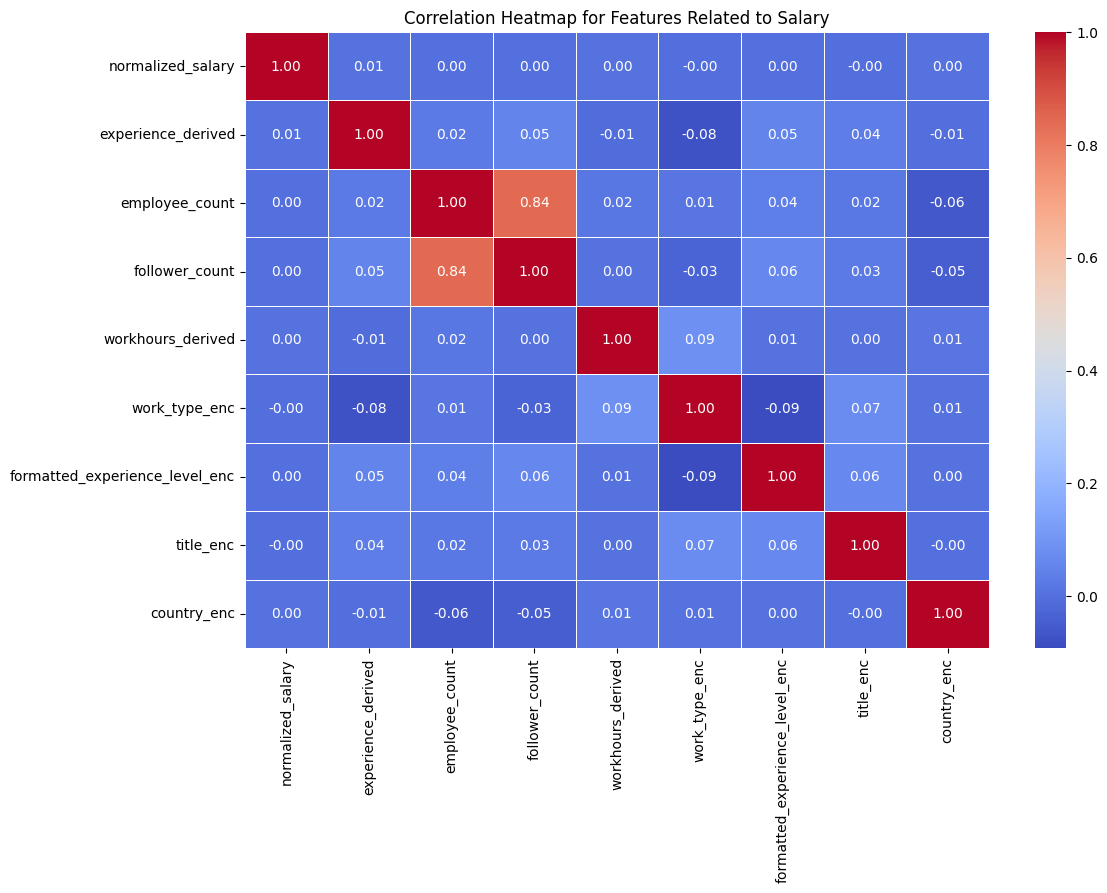

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = df_job_postings[
    [
        # "salary_calc",
        "normalized_salary",
        "experience_derived",
        "employee_count",
        "follower_count",
        "workhours_derived",
        "work_type_enc",
        "formatted_experience_level_enc",
        "title_enc",
        "country_enc",
    ]
].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Features Related to Salary")
plt.show()